### Import Packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import AgglomerativeClustering
from transformers import AutoTokenizer, AutoModel
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import torch
import nltk
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import string

from collections import Counter
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.naive_bayes import ComplementNB, GaussianNB

from scipy.stats import loguniform
from  sklearn.metrics  import accuracy_score,classification_report,roc_auc_score

import seaborn as sns
sns.set_theme()

/home/nina/Desktop/IMSP/LLM/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nina/Desktop/IMSP/LLM/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### Data Preprocessing

##### Data Loading

In [2]:
# Load German text dataset
df = pd.read_csv("bq-results-20230912-113230-1694518407919.csv")

# create dummy labels
df["Sales_Gesamt"] = np.random.choice([0,1], len(df))
df["VVL_Mobile"] = np.random.choice([0,1], len(df))
df["VVL_DSL"] = np.random.choice([0,1], len(df))
df["PO_GA"] = np.random.choice([0,1], len(df))
df["I@H_GA"] = np.random.choice([0,1], len(df))
df["TV_GA"] = np.random.choice([0,1], len(df))

In [3]:
df.head()

,filename,content,SOM,location,call_duration,Ariadne_internal_ID,Sales_Gesamt,VVL_Mobile,VVL_DSL,PO_GA,I@H_GA,TV_GA
0,SOM_118_00513_FA163E622DEB-1a7e-e29da700-832c3...,Herzlich willkommen bei O sein uns am Apparat ...,SOM,118,513,FA163E622DEB-1a7e-e29da700-832c3-64e3520f-7cef...,0,0,1,0,1,1
1,SOM_118_00513_FA163E52FD32-1a7e-2da87700-aa52c...,Willkommen bei der O Kundenbetreuung sie sprec...,SOM,118,513,FA163E52FD32-1a7e-2da87700-aa52c-64e76b65-aec3...,0,0,0,1,0,1
2,SOM_118_00513_FA163ED88855-1b1d-62522700-9f3ab...,Herzlich Willkommen hier ist die DSL und Techn...,SOM,118,513,FA163ED88855-1b1d-62522700-9f3ab-64e5fe14-2206...,1,0,0,0,1,0
3,SOM_118_00514_FA163E622DEB-1a7e-e61e1700-87f84...,Hallo schönen guten Tag herzlich willkommen be...,SOM,118,514,FA163E622DEB-1a7e-e61e1700-87f84-64e5d698-d607...,1,1,1,0,1,0
4,SOM_118_00259_FA163E52FD32-1a7e-2da87700-a5517...,Willkommen bei O so langsam Apparat\nEs ging e...,SOM,118,259,FA163E52FD32-1a7e-2da87700-a5517-64e5eed0-89ea...,1,1,0,1,1,0


In [6]:
# Load the spaCy German language model
nlp = spacy.load('de_core_news_sm')
# Create an empty list to store the updated text without proper names
updated_texts = []
# Iterate over the text column and remove proper names using spaCy
for text in df['content']:
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.pos_ != 'PROPN':
            tokens.append(token.text)
    updated_texts.append(' '.join(tokens))
# Update the 'text' column with the modified text
df['text'] = updated_texts

# Print the updated dataset
df.head()

/home/nina/Desktop/IMSP/LLM/.venv/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'de_core_news_sm' (3.6.0) was trained with spaCy v3.6.0 and may not be 100% compatible with the current version (3.7.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


,filename,content,SOM,location,call_duration,Ariadne_internal_ID,Sales_Gesamt,VVL_Mobile,VVL_DSL,PO_GA,I@H_GA,TV_GA,text
0,SOM_118_00513_FA163E622DEB-1a7e-e29da700-832c3...,Herzlich willkommen bei O sein uns am Apparat ...,SOM,118,513,FA163E622DEB-1a7e-e29da700-832c3-64e3520f-7cef...,1,1,0,1,1,0,Herzlich willkommen bei sein uns am Apparat wa...
1,SOM_118_00513_FA163E52FD32-1a7e-2da87700-aa52c...,Willkommen bei der O Kundenbetreuung sie sprec...,SOM,118,513,FA163E52FD32-1a7e-2da87700-aa52c-64e76b65-aec3...,1,0,1,0,1,0,Willkommen bei der Kundenbetreuung sie spreche...
2,SOM_118_00513_FA163ED88855-1b1d-62522700-9f3ab...,Herzlich Willkommen hier ist die DSL und Techn...,SOM,118,513,FA163ED88855-1b1d-62522700-9f3ab-64e5fe14-2206...,0,1,1,0,1,1,hier ist die und Technik Abteilung ich bräucht...
3,SOM_118_00514_FA163E622DEB-1a7e-e61e1700-87f84...,Hallo schönen guten Tag herzlich willkommen be...,SOM,118,514,FA163E622DEB-1a7e-e61e1700-87f84-64e5d698-d607...,1,1,1,1,1,0,schönen guten Tag herzlich willkommen bei ihne...
4,SOM_118_00259_FA163E52FD32-1a7e-2da87700-a5517...,Willkommen bei O so langsam Apparat\nEs ging e...,SOM,118,259,FA163E52FD32-1a7e-2da87700-a5517-64e5eed0-89ea...,0,1,1,1,1,1,Willkommen bei so langsam Apparat \n Es ging e...


##### Stopwords & Lemmatization

In [15]:
# Download the NLTK stop words list and wordnet for lemmatization
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the Snowball stemmer and WordNet lemmatizer
stemmer = SnowballStemmer("german")  # Use the appropriate language for stemming
lemmatizer = WordNetLemmatizer()

# Define a function to preprocess text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove punctuation and convert to lowercase
    tokens = [word.replace(".", "") for word in tokens]
    tokens = [word.replace("\n", "") for word in tokens]
    tokens = [word.replace(",", "") for word in tokens]
    tokens = [word.replace(",", "") for word in tokens]
    tokens = [word.lower() for word in tokens if word.isalnum()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('german'))  # Use the appropriate language
    tokens = [word for word in tokens if word not in stop_words]
    
    # Remove short words (length < 3 characters)
    tokens = [word for word in tokens if len(word) > 2]
    
    # Lemmatize or stem the words
    # Uncomment one of the following lines based on your choice
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    tokens = [stemmer.stem(word) for word in tokens]  # Stemming
    
    # Join the cleaned tokens back into a single string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Apply the preprocessing function to the DataFrame
df['text'] = df['text'].apply(preprocess_text)

# Print the cleaned DataFrame
print(df['text'])


[nltk_data] Downloading package stopwords to /home/nina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nina/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/nina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0        herzlich willkomm apparat tun muss mal guck ko...
1        willkomm kundenbetreu sprech darf tun dat stor...
2        technik abteil braucht kundennumm dat abgleich...
3        schon gut tag herzlich willkomm nam darf tun i...
4        willkomm langsam apparat ging halt rahm suppor...
                               ...                        
64530    hor gerad kolleg gesproch weitergeleitet deswe...
64531    wunderschon gut tag herzlich willkomm ausgezei...
64532    hallo nam ari gut wurd weitergeleitet indizier...
64533    herr gut tag kollegin gesagt problem rout korr...
64534    herr nam tun hallo person kundenkennzahl bitt ...
Name: text, Length: 64535, dtype: object


In [2]:
# store intermediate results
df.to_csv("preprocessed.csv", index=False)
# df = pd.read_csv("preprocessed.csv")

##### Words to remove

To decide what words will be removed, we look at the most frequent words and their meaning:

In [19]:
# get number of unique words:
word_set = set()
for row in df["text"]:
    word_set.update(row.split(" "))

len(word_set)

50598

In [20]:
# select the 100 most frequent words
most_frequent = Counter(" ".join(df["text"]).split()).most_common(100)
print([el[0] for el in most_frequent])

['genau', 'gut', 'bekomm', 'vertrag', 'dank', 'kurz', 'ganz', 'moment', 'sag', 'fall', 'nein', 'gern', 'numm', 'rufnumm', 'neu', 'monat', 'frag', 'seh', 'richtig', 'tarif', 'geht', 'leid', 'person', 'gesagt', 'war', 'gleich', 'rout', 'kundenkennzahl', 'muss', 'einfach', 'natur', 'per', 'mehr', 'geb', 'brauch', 'vielleicht', 'handy', 'imm', 'mocht', 'klein', 'klar', 'kart', 'schick', 'probl', 'syst', 'erst', 'gibt', 'steht', 'wunsch', 'wurd', 'bleib', 'sup', 'moglich', 'viel', 'angebot', 'kolleg', 'seit', 'darf', 'internet', 'weit', 'anruf', 'rabatt', 'weiss', 'gar', 'gemacht', 'rechnung', 'bewert', 'heut', 'adress', 'wart', 'dat', 'gesprach', 'versteh', 'end', 'wirklich', 'bissch', 'zahl', 'krieg', 'bestat', 'wiss', 'beispiel', 'eigent', 'nach', 'tschuss', 'kommt', 'sprech', 'technik', 'geh', 'komm', 'kundig', 'kund', 'musst', 'jahr', 'leitung', 'morg', 'sofort', 'uhr', 'selb', 'alt', 'wann']


In [21]:
# Words to remove
words_to_remove =  most_frequent + ["herr", "hallo", "willkomm", "herzlich", "mal", "tun", "tag", "nam", "guck", "sau", "bitt", 
                                   "halt", "gerad", "weil", "desweg", "gruss", "schon", "abend", "irgendwie", "schau", "nachmittag", "aha",
                                   "gott", "frau", "opus", "herrn", "irgendwo"]

# Function to remove specified words from text
def remove_specific_words(text, words_to_remove):
    # Tokenize the text
    tokens = text.split(" ")
    
    # Filter out words to remove
    filtered_tokens = [word for word in tokens if word not in words_to_remove]
    
    # Join the remaining tokens back into a single string
    cleaned_text = ' '.join(filtered_tokens)
    
    return cleaned_text

# Apply the function to the 'cleaned_text' column
df['text'] = df['text'].apply(lambda x: remove_specific_words(x, words_to_remove))

# Print the cleaned DataFrame
print(df['text'])


0        apparat muss konto gern aktuell stand ding gem...
1        kundenbetreu sprech darf dat storni raus berei...
2        technik abteil braucht kundennumm dat abgleich...
3        gut darf internet haus funktioniert internet h...
4        langsam apparat ging rahm support muss kund ge...
                               ...                        
64530    hor kolleg gesproch weitergeleitet mocht gern ...
64531    wunderschon gut ausgezeichnet wichtig technik ...
64532    ari gut wurd weitergeleitet indiziert adress s...
64533    gut kolleg gesagt problem rout korrekt genau f...
64534    person kundenkennzahl worum geht rechnung ruf ...
Name: text, Length: 64535, dtype: object


In [22]:
# replace words with equal interpretation 
df["text"] = df["text"].apply(lambda x: x.replace("kollegin", "kolleg"))
df["text"] = df["text"].apply(lambda x: x.replace("nee", "nein"))


In [23]:
# remove names
names = pd.read_csv("first-names.txt",header=None)[0].to_list()
df['text'] = df['text'].apply(lambda x: remove_specific_words(x, names))


##### Store preprocessing steps

In [24]:
df.to_csv("preprocessed.csv", index=False)

In [3]:
df = pd.read_csv("preprocessed.csv")
# df[features+targets].head()

##### Train-Test Split

In [4]:
features = ["text","location", "call_duration"]
targets = ['Sales_Gesamt', 'VVL_Mobile', 'VVL_DSL', 'PO_GA','I@H_GA', 'TV_GA']
X_train, X_test = train_test_split(df[features + targets], test_size=0.2, random_state=42)


In [5]:
print(len(X_train), len(X_test))

51628 12907


##### Create word vectorization (Bag of Words with TfidVectorizer)

In [6]:
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train["text"])
test_vectors = vectorizer.transform(X_test["text"])
print(train_vectors.shape, test_vectors.shape)

(51628, 45402) (12907, 45402)


## Classification (classical models)

### Hyperparameter Search

#### Complement Naive Bayes

In [9]:
# Define hyperparameter grid
alpha_range = loguniform(1e-2,1e1)
parameter_grid = {'alpha':alpha_range, 'norm':[True, False]}
randomsearch_CNB = ComplementNB()
randomsearch_clf = RandomizedSearchCV(randomsearch_CNB, parameter_grid,cv=10,scoring = "roc_auc", n_iter=50)

In [17]:
# Train all targets independently from one another
# and store relevant results in data frame for later comparison
df_res = pd.DataFrame()
for target_id in range(len(targets)):
    randomsearch_clf.fit(train_vectors,X_train[targets[target_id]])
    
    class_rep = classification_report(randomsearch_clf.best_estimator_.predict(test_vectors),X_test[targets[target_id]],output_dict =True)
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    res["target"] = targets[target_id]
    print(targets[target_id])
    print(randomsearch_clf.best_estimator_.get_params())
    res["model"] = "ComplementNB"
    df_res = pd.concat((df_res,res), ignore_index=True)

Sales_Gesamt
{'alpha': 0.09428134981759423, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn', 'norm': True}
VVL_Mobile
{'alpha': 2.9290369419637496, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn', 'norm': False}
VVL_DSL
{'alpha': 1.548555923821995, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn', 'norm': False}
PO_GA
{'alpha': 0.5961544177707631, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn', 'norm': False}
I@H_GA
{'alpha': 4.598846256772761, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn', 'norm': False}
TV_GA
{'alpha': 9.411635502921792, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn', 'norm': False}


In [16]:
df_res.tail()

,metric,subclass,value,target,model
103,precision,1,0.494844,TV_GA,ComplementNB
104,recall,1,0.500545,TV_GA,ComplementNB
105,f1-score,1,0.497678,TV_GA,ComplementNB
106,support,1,6423.0,TV_GA,ComplementNB
107,accuracy,None,0.497172,TV_GA,ComplementNB


#### SVC

In [7]:
# Train all targets independently from one another
# and store relevant results in data frame for later comparison
c_range = loguniform(1e-1,1e2)
degree_range = np.arange(1,5,1)
parameter_grid = {'C':c_range,
                  "kernel":["linear", "poly", "rbf", "sigmoid"],
                  "degree":degree_range,
                  "gamma":["scale","auto"],
                  "decision_function_shape":['ovo','ovr']}

randomsearch_SVC = SVC(probability=True)
randomsearch_clf_SVC = RandomizedSearchCV(randomsearch_SVC, parameter_grid,cv=10,scoring = "roc_auc", n_iter=50)

for target_id in range(len(targets)):
    randomsearch_clf_SVC.fit(train_vectors,X_train[targets[target_id]])
    
    class_rep = classification_report(randomsearch_clf_SVC.best_estimator_.predict(test_vectors),X_test[targets[target_id]],output_dict =True)
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    res["target"] = targets[target_id]
    print(targets[target_id])
    print(randomsearch_clf.best_estimator_.get_params())
    res["model"] = "SVC"
    df_res = pd.concat((df_res,res), ignore_index=True)
    break

#### Random Forest

In [ ]:
parameter_grid = {"n_estimators": np.arange(80, 200, 1),
                  "min_samples_split": np.arange(2, 10, 1),
                  "min_samples_leaf": np.arange(1, 5, 1),
                  "criterion":["gini", "entropy", "log_loss"],
                  "class_weight":["balanced", "balanced_subsample",None],
                  }

randomsearch_RFC = RandomForestClassifier()
randomsearch_clf_RFC = RandomizedSearchCV(randomsearch_RFC, parameter_grid,cv=10,scoring = "roc_auc", n_iter=100)

for target_id in range(len(targets)):
    randomsearch_clf_RFC.fit(train_vectors,X_train[targets[target_id]])
    class_rep = classification_report(randomsearch_clf_RFC.best_estimator_.predict(test_vectors),X_test[targets[target_id]],output_dict =True)
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    res["target"] = targets[target_id]
    print(targets[target_id])
    print(randomsearch_clf.best_estimator_.get_params())
    res["model"] = "RandomForest"
    df_res = pd.concat((df_res,res), ignore_index=True)

#### XGBoost

In [ ]:
parameter_grid = {"n_estimators": np.arange(80, 200, 1),
                  "learning_rate": loguniform(1e-3, 1e0),
                  "max_depth": np.arange(2, 6, 1),
                  "criterion":['squared_error', 'friedman_mse'],
                  }

randomsearch_XGBC = GradientBoostingClassifier()
randomsearch_clf_XGBC = RandomizedSearchCV(randomsearch_XGBC, parameter_grid,cv=10,scoring = "roc_auc", n_iter=100)

for target_id in range(len(targets)):
    randomsearch_clf_XGBC.fit(train_vectors,X_train[targets[target_id]])
    class_rep = classification_report(randomsearch_clf_XGBC.best_estimator_.predict(test_vectors),X_test[targets[target_id]],output_dict =True)
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    res["target"] = targets[target_id]
    print(targets[target_id])
    print(randomsearch_clf.best_estimator_.get_params())
    res["model"] = "XGBoost"
    df_res = pd.concat((df_res,res), ignore_index=True)

#### Gaussian Naive Bayes

In [11]:
for target_id in range(len(targets)):
    # no HP for GNB
    NBC = GaussianNB()
    NBC.fit(train_vectors.toarray(),X_train[targets[target_id]])
    class_rep = classification_report(NBC.predict(test_vectors.toarray()),X_test[targets[target_id]],output_dict =True)
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    res["target"] = targets[target_id]
    print(targets[target_id])
    print(randomsearch_clf.best_estimator_.get_params())
    res["model"] = "GaussianNaiveBayes"
    df_res = pd.concat((df_res,res), ignore_index=True)

#### AdaBoost Classifier

In [ ]:
parameter_grid = {"n_estimators": np.arange(30, 100, 1),
                  "learning_rate": loguniform(1e-1, 1e1)
                  }

randomsearch_ABC = AdaBoostClassifier()
randomsearch_clf_ABC = RandomizedSearchCV(randomsearch_ABC, parameter_grid,cv=10,scoring = "roc_auc", n_iter=20)

for target_id in range(len(targets)):
    randomsearch_clf_ABC.fit(train_vectors,X_train[targets[target_id]])
    class_rep = classification_report(randomsearch_clf_ABC.best_estimator_.predict(test_vectors),X_test[targets[target_id]],output_dict =True)
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    res["target"] = targets[target_id]
    print(targets[target_id])
    print(randomsearch_clf.best_estimator_.get_params())
    res["model"] = "AdaBoost"
    df_res = pd.concat((df_res,res), ignore_index=True)

#### Gaussian Process Classifier

In [ ]:
parameter_grid = {"kernel": [1.0 * RBF(length_scale=1.15), 1.0 * DotProduct(sigma_0=1.0) ** 2]}

# gridsearch since we're comparing exactly two settings
gridsearch_GPC = GaussianProcessClassifier()
gridsearch_clf_GPC = GridSearchCV(gridsearch_GPC, parameter_grid,cv=2,scoring = "roc_auc")

for target_id in range(len(targets)):
    gridsearch_clf_GPC.fit(train_vectors.toarray(),np.array(X_train[targets[target_id]]))
    class_rep = classification_report(gridsearch_clf_GPC.best_estimator_.predict(test_vectors.toarray()),np.array(X_test[targets[target_id]]),output_dict =True)
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    res["target"] = targets[target_id]
    print(targets[target_id])
    print(randomsearch_clf.best_estimator_.get_params())
    res["model"] = "GaussianProcess"
    df_res = pd.concat((df_res,res), ignore_index=True)

#### MLP Classifier

In [ ]:
parameter_grid = {"hidden_layer_sizes": [(100,), (32,32,32), (32,32,32,32), (32,32,32,32,32), (64,64,64), (64,64)],
                  "activation": ["logistic", "tanh", "relu"],
                  "learning_rate_init": loguniform(1e-4, 1e-1)
                  }

randomsearch_MLPC = MLPClassifier()
randomsearch_clf_MLPC = RandomizedSearchCV(randomsearch_MLPC, parameter_grid,cv=10,scoring = "roc_auc", n_iter=100)

for target_id in range(len(targets)):
    randomsearch_clf_MLPC.fit(train_vectors,X_train[targets[target_id]])
    class_rep = classification_report(randomsearch_clf_MLPC.best_estimator_.predict(test_vectors),X_test[targets[target_id]],output_dict =True)
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    res["target"] = targets[target_id]
    print(targets[target_id])
    print(randomsearch_clf.best_estimator_.get_params())
    res["model"] = "MLPClassifier"
    df_res = pd.concat((df_res,res), ignore_index=True)

### Evaluation

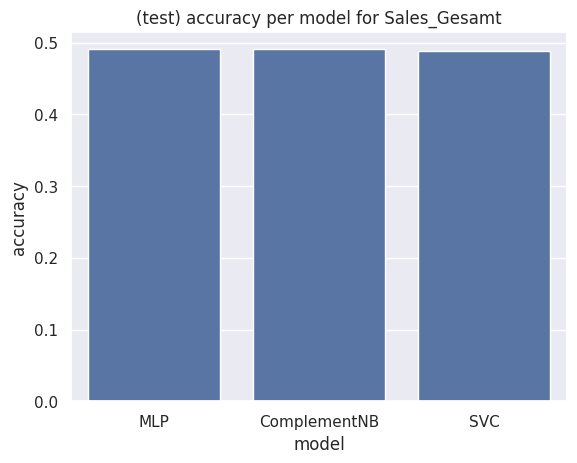

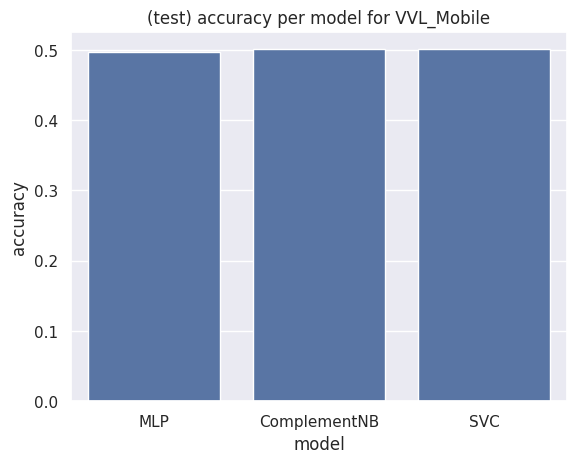

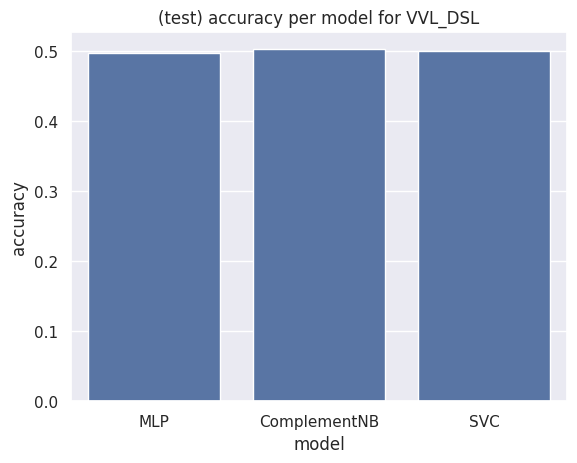

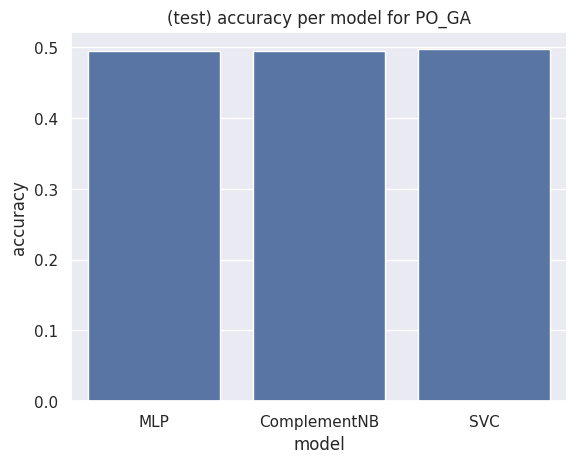

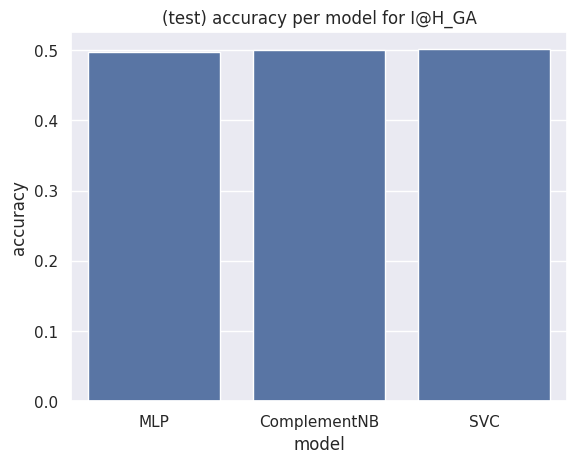

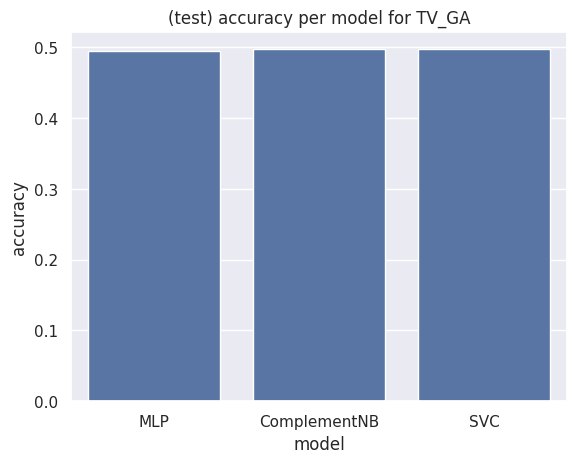

In [18]:
for variable in targets:
    sns.barplot(df_res.loc[(df_res["metric"]=="accuracy") & (df_res["target"]==variable)], x="model", y="value")
    plt.title(f"(test) accuracy per model for {variable}")
    plt.ylabel("accuracy")
    plt.show()


In [19]:
df_res

,metric,subclass,value,target,model
0,precision,0,0.638444,Sales_Gesamt,MLP
1,recall,0,0.490963,Sales_Gesamt,MLP
2,f1-score,0,0.555074,Sales_Gesamt,MLP
3,support,0,8355.0,Sales_Gesamt,MLP
4,precision,1,0.343875,Sales_Gesamt,MLP
...,...,...,...,...,...
157,precision,1,0.198861,TV_GA,SVC
158,recall,1,0.501748,TV_GA,SVC
159,f1-score,1,0.284832,TV_GA,SVC
160,support,1,2575.0,TV_GA,SVC


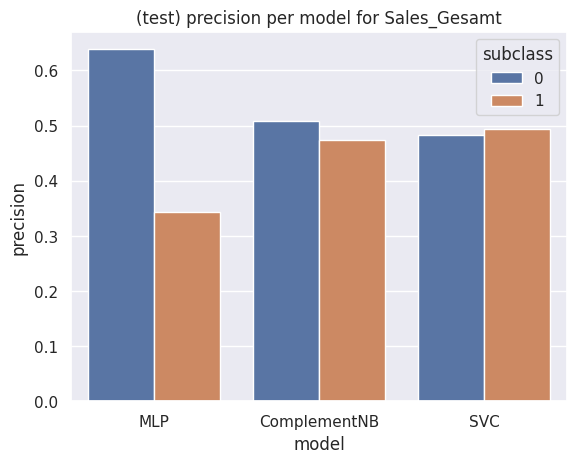

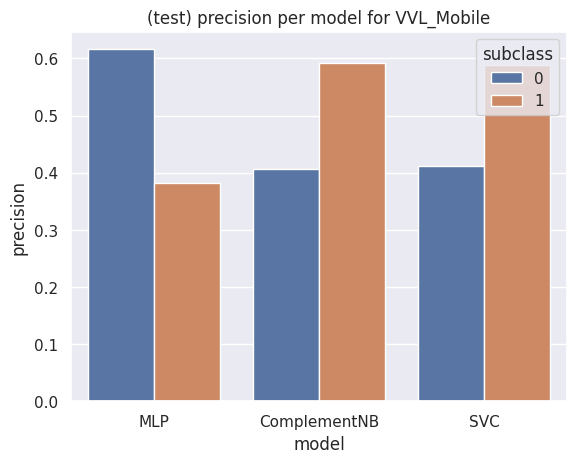

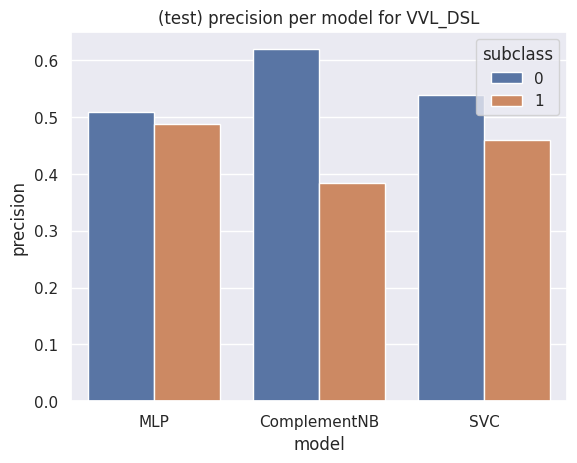

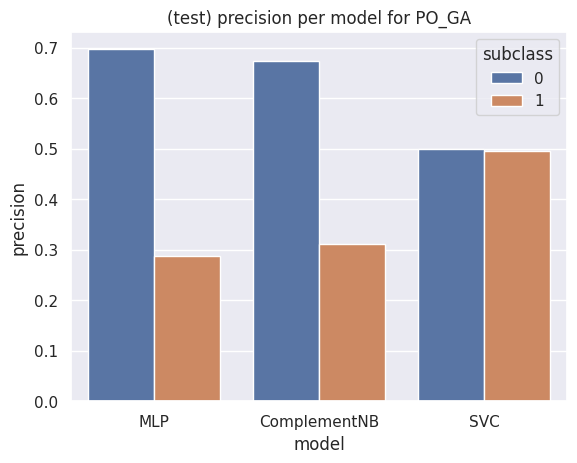

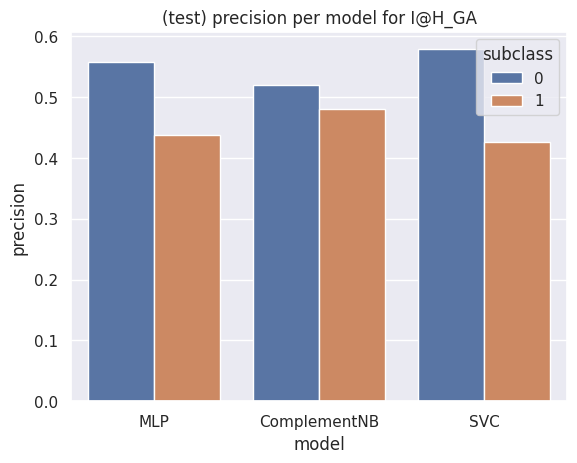

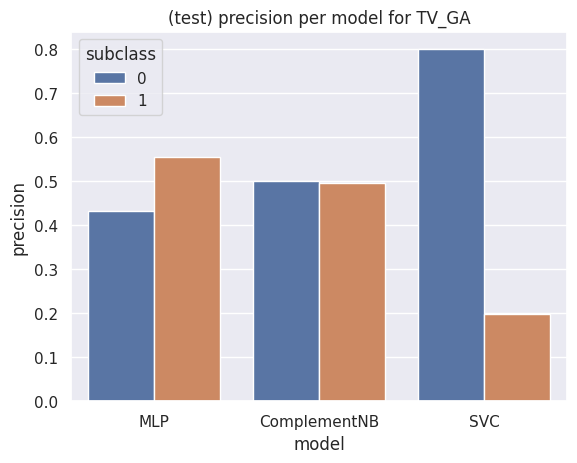

In [21]:
for variable in targets:
    sns.barplot(df_res.loc[(df_res["metric"]=="precision") & (df_res["target"]==variable)], x="model", y="value", hue="subclass")
    plt.title(f"(test) precision per model for {variable}")
    plt.ylabel("precision")
    plt.show()

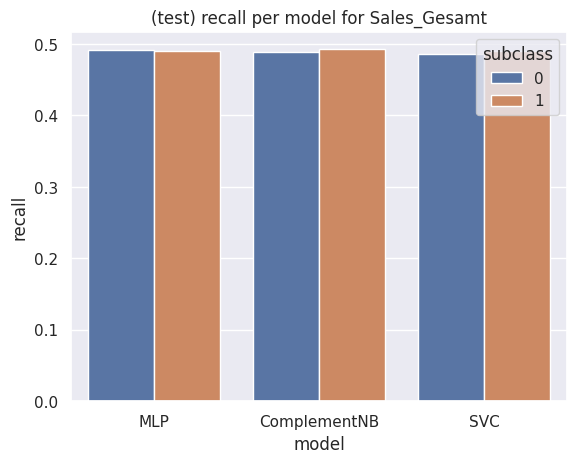

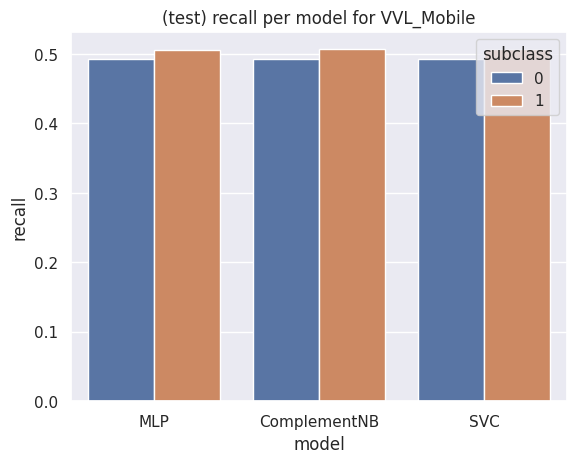

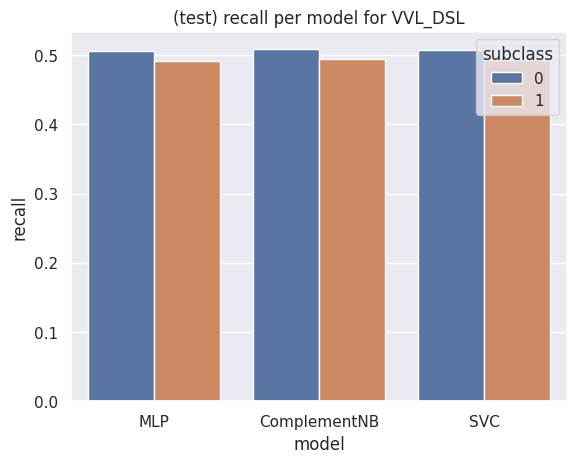

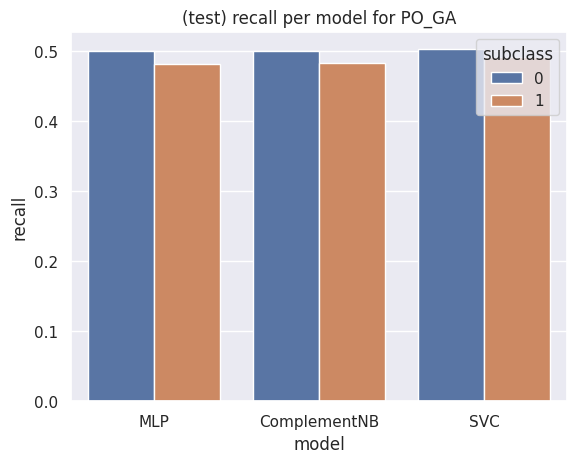

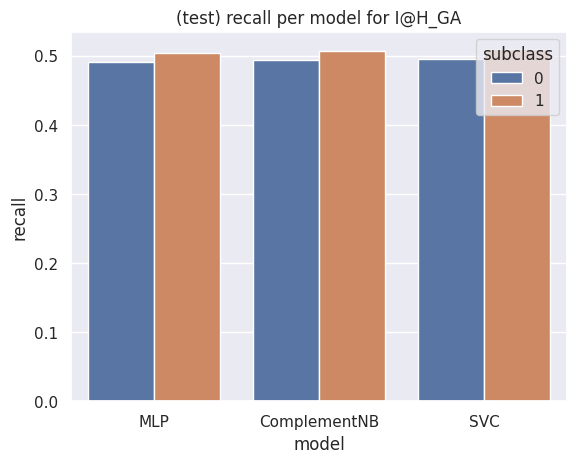

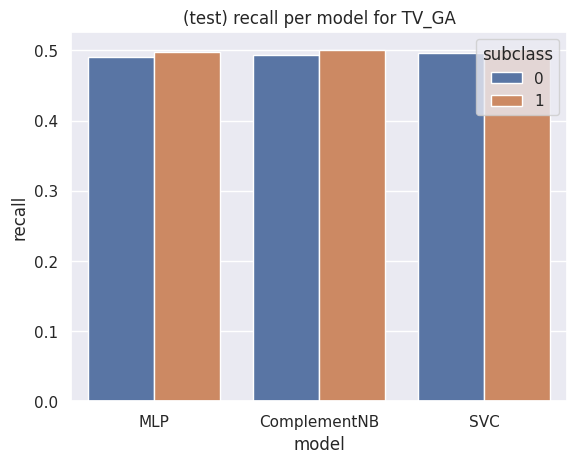

In [28]:
for variable in targets:
    sns.barplot(df_res.loc[(df_res["metric"]=="recall") & (df_res["target"]==variable)], x="model", y="value", hue="subclass")
    plt.title(f"(test) recall per model for {variable}")
    plt.ylabel("recall")
    plt.show()

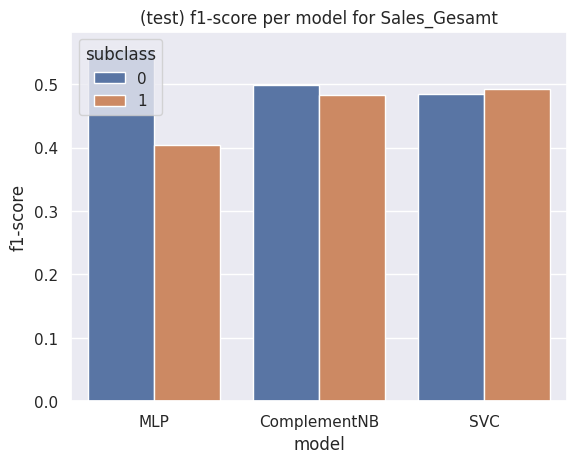

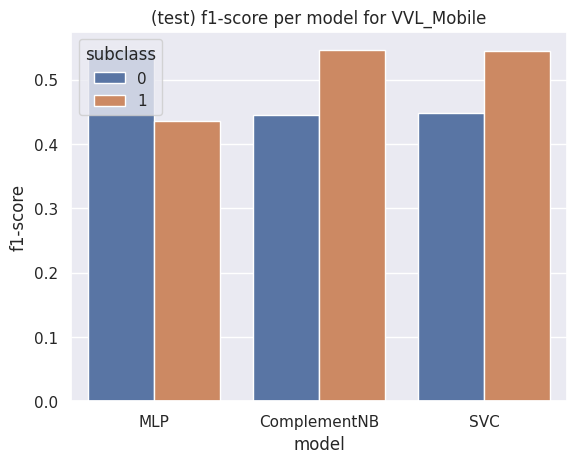

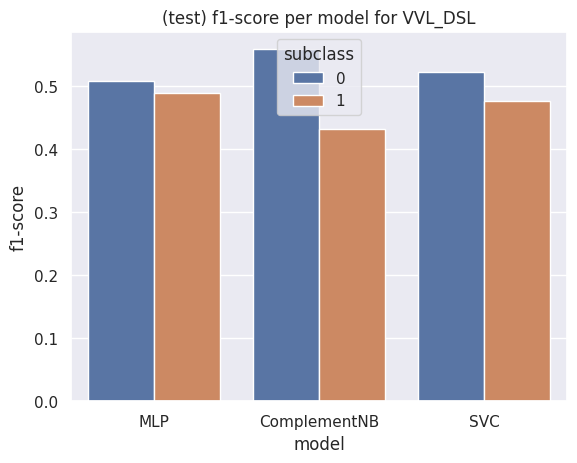

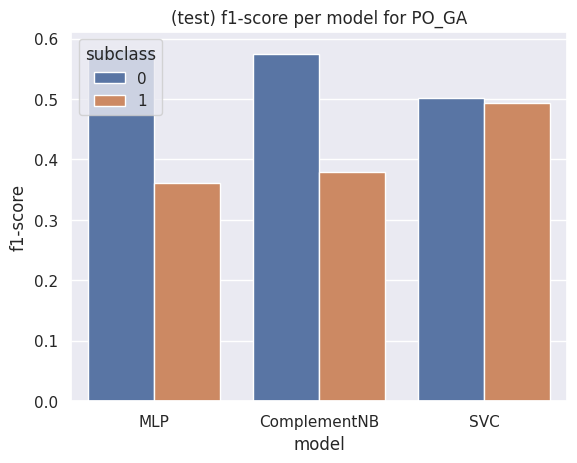

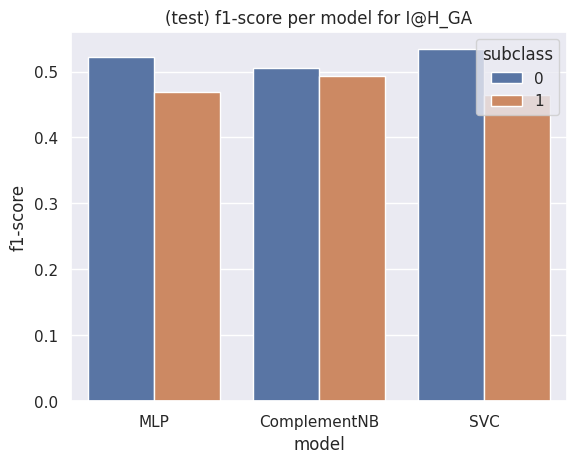

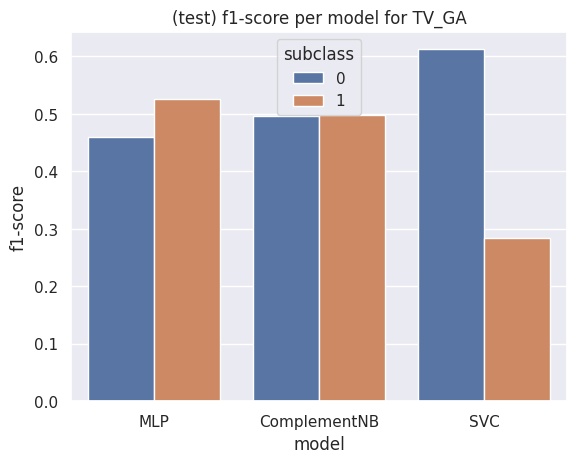

In [29]:
for variable in targets:
    sns.barplot(df_res.loc[(df_res["metric"]=="f1-score") & (df_res["target"]==variable)], x="model", y="value", hue="subclass")
    plt.title(f"(test) f1-score per model for {variable}")
    plt.ylabel("f1-score")
    plt.show()

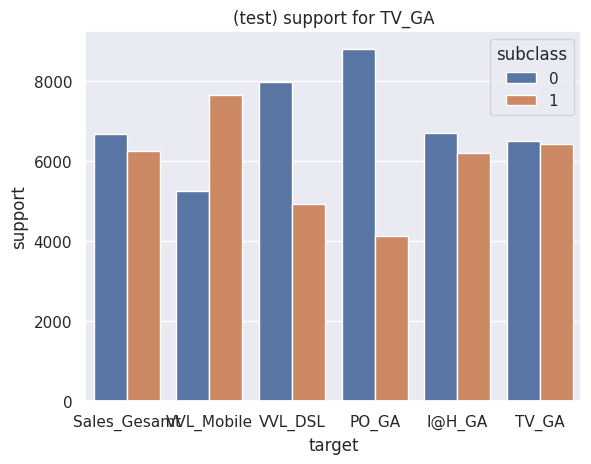

In [27]:
sns.barplot(df_res.loc[(df_res["metric"]=="support") & (df_res["model"]=="ComplementNB")], x="target", y="value", hue="subclass")
plt.title(f"(test) support for variables")
plt.ylabel("support")
plt.show()

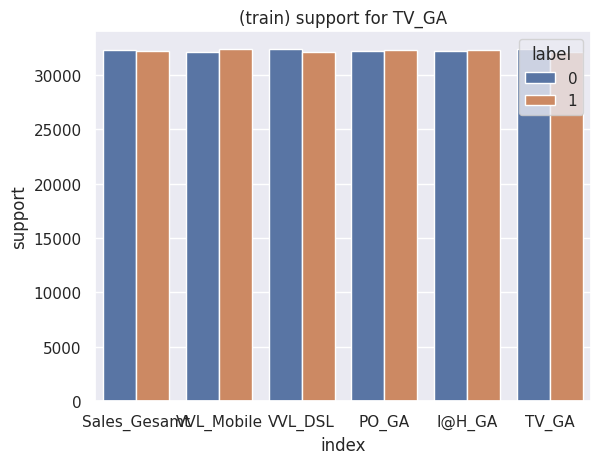

In [48]:
df_res2 = pd.DataFrame()
df_res2["value"] = df[targets].sum()
df_res2.reset_index(inplace=True)
df_res2.rename({"index": "target"}, axis=1)
df_res2["label"] = 1
df_res3 = df_res2.copy()
df_res3["label"] = 0
df_res3["value"] = df[targets].count().iloc[0] - df_res3["value"]
sns.barplot(pd.concat((df_res2, df_res3), ignore_index=True), x="index", y="value", hue="label")
plt.title(f"(train) support for variables")
plt.ylabel("support")
plt.show()

## Classification (LLM using OpenAI)

In [14]:
# # pip install scikit-llm[annoy]
from skllm import DynamicFewShotGPTClassifier
from skllm.memory._annoy import AnnoyMemoryIndex
from skllm.memory.base import IndexConstructor
from skllm.config import SKLLMConfig 
from skllm.models.palm import PaLMClassifier

SKLLMConfig.set_openai_key("OPENAI_API_KEY")
SKLLMConfig.set_openai_org("OPENAI_API_ORG")

### Model training without further preprocessing

#### Dnymamic Few Shot GPT-3.5-turbo Classifier with Annoy Memory Index

In [ ]:
df_res_LLM = pd.DataFrame()
for target_id in range(len(targets)):
    # Since most features are not descriptive, we cannot use the zeroshot GPT classifier
    # furthermore, we have more than 10 samples per label --> 
    index = IndexConstructor(AnnoyMemoryIndex) # for faster performance use annoy
    clf_gpt_3 = DynamicFewShotGPTClassifier(n_examples=3, openai_model = "gpt-3.5-turbo", memory_index=index, n_epochs = None)
    # Fit/Train our model
    clf_gpt_3.fit(X_train[features], X_train[targets[target_id]])
    labels = clf_gpt_3.predict(X_test)
        
    class_rep = classification_report(labels, X_test[targets[target_id]],output_dict =True)
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    res["target"] = targets[target_id]
    print(targets[target_id])
    res["model"] = "GPT-3.5-turbo"
    df_res_LLM = pd.concat((df_res_LLM,res), ignore_index=True)

#### Dnymamic Few Shot GPT-4 Classifier with Annoy Memory Index

In [ ]:
for target_id in range(len(targets)):
    # Since most features are not descriptive, we cannot use the zeroshot GPT classifier
    # furthermore, we have more than 10 samples per label --> 
    index = IndexConstructor(AnnoyMemoryIndex) # for faster performance use annoy
    clf_gpt_4 = DynamicFewShotGPTClassifier(n_examples=3, openai_model = "gpt-4", memory_index=index, n_epochs = None)
    # Fit/Train our model
    clf_gpt_4.fit(X_train[features], X_train[targets[target_id]])
    labels = clf_gpt_4.predict(X_test)
        
    class_rep = classification_report(labels, X_test[targets[target_id]],output_dict =True)
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    res["target"] = targets[target_id]
    print(targets[target_id])
    res["model"] = "gpt-4"
    df_res_LLM = pd.concat((df_res_LLM,res), ignore_index=True)

#### PaLM Classifier

In [ ]:
for target_id in range(len(targets)):
    # Googles PaLM model
    clf_palm = PaLMClassifier(n_update_steps=100)
    clf_palm.fit(X_train[features], X_train[targets[target_id]])
    labels = clf_palm.predict(X_test)
        
    class_rep = classification_report(labels, X_test[targets[target_id]],output_dict =True)
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    res["target"] = targets[target_id]
    print(targets[target_id])
    res["model"] = "gpt-4"
    df_res_LLM = pd.concat((df_res_LLM,res), ignore_index=True)

### Evaluation

In [ ]:
for variable in targets:
    sns.barplot(df_res_LLM.loc[(df_res["metric"]=="accuracy") & (df_res_LLM["target"]==variable)], x="model", y="value")
    plt.title(f"(test) accuracy per model for {variable}")
    plt.ylabel("accuracy")
    plt.show()

In [ ]:
for variable in targets:
    sns.barplot(df_res.loc[(df_res["metric"]=="precision") & (df_res["target"]==variable)], x="model", y="value", hue="subclass")
    plt.title(f"(test) precision per model for {variable}")
    plt.ylabel("precision")
    plt.show()

In [ ]:
for variable in targets:
    sns.barplot(df_res.loc[(df_res["metric"]=="recall") & (df_res["target"]==variable)], x="model", y="value", hue="subclass")
    plt.title(f"(test) recall per model for {variable}")
    plt.ylabel("recall")
    plt.show()

In [ ]:
for variable in targets:
    sns.barplot(df_res.loc[(df_res["metric"]=="f1-score") & (df_res["target"]==variable)], x="model", y="value", hue="subclass")
    plt.title(f"(test) f1-score per model for {variable}")
    plt.ylabel("f1-score")
    plt.show()

## Classification LLM (using BERT)

In [6]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [28]:
target_names = ['Sales_Gesamt', 'VVL_Mobile', 'VVL_DSL', 'PO_GA','I@H_GA', 'TV_GA']

In [29]:
# Tokenize the input text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, target_column):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['text']
        self.targets = self.data[target_column]
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        target = self.targets[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.long)
        }

# Define hyperparameters
MAX_LEN = 128
BATCH_SIZE = 16

In [14]:
df_res_BERT = pd.DataFrame()

for target_column in target_names:
    # Create DataLoader
    train_dataset = CustomDataset(X_train.reset_index()[["index", "text", target_column]], tokenizer, MAX_LEN, target_column=target_column)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    test_dataset = CustomDataset(X_test.reset_index()[["index", "text", target_column]], tokenizer, MAX_LEN, target_column=target_column)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Load pre-trained BERT model for sequence classification
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = torch.nn.CrossEntropyLoss()

    # Training loop
    EPOCHS = 3

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, total=len(train_loader), desc=f'Epoch {epoch + 1}/{EPOCHS}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(torch.float32).to(device)
            targets = batch['target'].to(torch.float32).to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask, labels=targets)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
        
        average_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {average_loss:.4f}')

    # Evaluation
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in tqdm(test_loader, total=len(test_loader), desc='Evaluating'):
            input_ids = batch['input_ids'].to(torch.float32).to(device)
            attention_mask = batch['attention_mask'].to(torch.float32).to(device)
            targets = batch['target'].to(torch.float32).to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_targets, all_predictions)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    class_rep = classification_report(all_targets, all_predictions, output_dict =True)
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    res["target"] = target_column
    res["model"] = "BERT"
    df_res_BERT = pd.concat((df_res_BERT,res), ignore_index=True)


Epoch 1/3:   0%|          | 0/3227 [00:03<?, ?it/s]


Epoch 1/3, Loss: 0.0001


Epoch 2/3:   0%|          | 0/3227 [00:03<?, ?it/s]


Epoch 2/3, Loss: 0.0001


Epoch 3/3:   0%|          | 0/3227 [00:03<?, ?it/s]


Epoch 3/3, Loss: 0.0001


Evaluating: 100%|██████████| 807/807 [13:45<00:00,  1.02s/it]

Accuracy: 49.32%


## Word Association Graph